### Custom LeNet Model
- Scalp Image Classification 
- Hair loss symptom 0,1,2,3

- 파라미터들과 모델 깊이를 변형하며 학습해본 결과, 주어진 데이터의 양이 적어서 epoch을 늘리면 과적합이 쉽게 일어났다.
- 모델 깊이가 얕으면 최적의 성능을 내기가 어려웠다.
- 모델 깊이를 깊게 하고, 데이터 증강을 하고 한 증강 세트 당 2~3번 이내로 Train하는 과정을 반복하는 것이 가장 좋은 성능을 보일 것이라고 생각하였다.

---

4개 층의 모델로 증강/훈련 반복 진행

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

# GPU가 사용 가능한 경우 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_data():
    # 데이터 전처리 및 로드
    transform = transforms.Compose([
        transforms.Resize((300, 300)),  # 이미지 크기 조정
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    ])
    train_dataset = datasets.ImageFolder('./Training/hairloss', transform=transform)
    test_dataset = datasets.ImageFolder('./Validation/hairloss', transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    return train_loader, test_loader

# CNN 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(128 * 18 * 18, 4)  # 분류할 클래스 수에 맞게 설정

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# 모델 초기화
model = CNN().to(device)

# 손실 함수와 최적화 알고리즘 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 학습 함수
def train(model, criterion, optimizer, train_loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    print('train_accuracy: ', 100 * correct / total)

    return train_loss


# 테스트 함수
def test(model, criterion, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    return test_accuracy

# 손실 그래프 그리기
def draw_loss(train_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [10]:
train_loader, test_loader = get_data()
train_losses = []
for epoch in range(2):
    train_loss = train(model, criterion, optimizer, train_loader)
    test_accuracy = test(model, criterion, test_loader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{5}, Train Loss: {train_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

train_accuracy:  73.5753254469832
Epoch 1/5, Train Loss: 0.6851
Test Accuracy: 74.11%
train_accuracy:  74.68805704099822
Epoch 2/5, Train Loss: 0.6382
Test Accuracy: 73.54%


In [28]:
def augdata():
    transform = transforms.Compose([
        transforms.Resize((300, 300)),  # 이미지 크기 조정
        transforms.RandomHorizontalFlip(),  # 무작위로 좌우 반전
        transforms.RandomRotation(10),  # 무작위로 회전
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 색상 변형
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    aug_train_dataset = datasets.ImageFolder('./Training/hairloss', transform=transform)
    aug_train_loader = DataLoader(aug_train_dataset, batch_size=32, shuffle=True)
    return aug_train_loader

In [30]:
aug_train_loader = augdata()
aug_train_losses = []
for epoch in range(2):
    train_loss = train(model, criterion, optimizer, aug_train_loader)
    test_accuracy = test(model, criterion, test_loader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{5}, Train Loss: {train_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

train_accuracy:  73.58072705666288
Epoch 1/5, Train Loss: 0.6774
Test Accuracy: 73.83%
train_accuracy:  74.32074758277967
Epoch 2/5, Train Loss: 0.6553
Test Accuracy: 74.34%


In [32]:
aug_train_loader = augdata()
aug_train_losses = []
for epoch in range(3):
    train_loss = train(model, criterion, optimizer, aug_train_loader)
    test_accuracy = test(model, criterion, test_loader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{3}, Train Loss: {train_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

train_accuracy:  74.6934586506779
Epoch 1/3, Train Loss: 0.6435
Test Accuracy: 73.68%
train_accuracy:  75.12558742505267
Epoch 2/3, Train Loss: 0.6369
Test Accuracy: 74.47%
train_accuracy:  75.23902122832604
Epoch 3/3, Train Loss: 0.6286
Test Accuracy: 75.17%


In [33]:
# 저장
# 75.17%
torch.save(model.state_dict(), './LeNetmodel.pth')

In [34]:
#aug_train_loader = augdata()
#aug_train_losses = []
for epoch in range(1):
    train_loss = train(model, criterion, optimizer, aug_train_loader)
    test_accuracy = test(model, criterion, test_loader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{3}, Train Loss: {train_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

train_accuracy:  75.40106951871658
Epoch 1/3, Train Loss: 0.6216
Test Accuracy: 74.34%


In [23]:
CNNmodel = CNN()  # 또는 해당 모델의 인스턴스를 생성
CNNmodel.load_state_dict(torch.load('Lenetmodel.pth'))

<All keys matched successfully>

In [36]:
aug_train_loader = augdata()
aug_train_losses = []
for epoch in range(2):
    train_loss = train(CNNmodel, criterion, optimizer, aug_train_loader)
    test_accuracy = test(CNNmodel, criterion, test_loader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{3}, Train Loss: {train_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

train_accuracy:  75.40106951871658
Epoch 1/3, Train Loss: 0.6705
Test Accuracy: 75.17%
train_accuracy:  75.38486468967753
Epoch 2/3, Train Loss: 0.6692
Test Accuracy: 75.17%


In [37]:
aug_train_loader = augdata()
aug_train_losses = []
for epoch in range(2):
    train_loss = train(CNNmodel, criterion, optimizer, aug_train_loader)
    test_accuracy = test(CNNmodel, criterion, test_loader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{2}, Train Loss: {train_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

train_accuracy:  75.40647112839626
Epoch 1/2, Train Loss: 0.6684
Test Accuracy: 75.17%
train_accuracy:  75.40647112839626
Epoch 2/2, Train Loss: 0.6716
Test Accuracy: 75.17%


---

이미지 한개 결과 출력하기

In [ ]:
import random

# train은 훈련용이라 test에서 선택하는게 더 의미있을 것 같아서 test에서 데이터 임의 선택.
random_index = random.randint(0, len(train_loader.dataset) - 1)
data, label = train_loader.dataset[random_index]

# 1개 데이터를 치원 확장해서 모델에 전달
data = data.unsqueeze(0).to(device)
output = model(data)

_, predicted = torch.max(output.data, 1)

print('예측 클래스:', predicted.item())
print('실제 클래스:', label)


---

LeNet, DenseNet, ResNet의 성능 비교 시각화

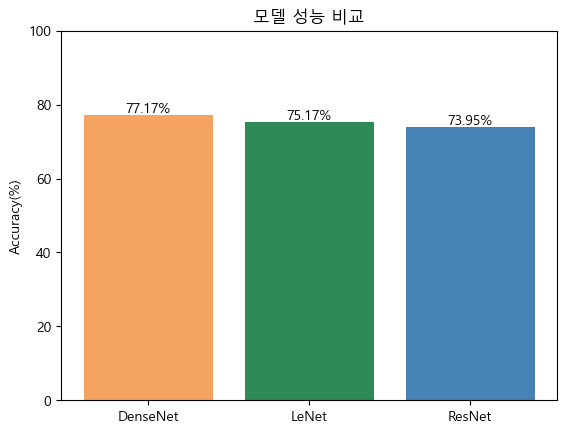

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='Malgun Gothic')
values = [77.17, 75.17, 73.95]
labels = ['DenseNet', 'LeNet', 'ResNet']

plt.bar(labels, values, color=['sandybrown', 'seagreen', 'steelblue'])
#plt.yticks(range(0, 101, 10))
plt.ylim([0, 100])
plt.ylabel('Accuracy(%)')
plt.title('모델 성능 비교')

for i, v in enumerate(values):
    plt.text(i, v, f'{v:.2f}%', ha='center', va='bottom')

plt.show()